# Blockwise Data Overview / Preprocessing

## Imports

In [5]:
import JSON
import GZip
using Statistics
using StatsPlots
using DataFramesMeta
using FileIO
import JLD2

In [6]:
using RLSR

## Subject Data Parameters

In [10]:
data_dir = "../data"
img_dir = "./img"
derived_dir = "../../derived"
study_dir = "blockwise"

node_ids = ["0.0-8.0"]
study_name = "blockwise"
file_prefix = "blockwise"
ntrials = 400
data_ids = [
    #"",
    #"",
    #"",
]
filenames = "$(data_dir)/$(study_dir)/" .* data_ids .* ".json.gz"
NS = length(filenames)
println("$(NS) SUBJECTS")

104 SUBJECTS


## Load Data

In [11]:
function json_to_ep_vector(filename)
    dictlist = JSON.parse(GZip.open(filename))
    trials = Vector{Episode}()
    boat_rts = Vector()
    island_rts = Vector()
    magnitude_results = Vector()
    evenodd_results = Vector()
    mean_reward_prob = Vector()
    reward_probs = Vector()
    trial_rts_boat = Vector()
    trial_rts_island = Vector()
    for row in dictlist
        if any([startswith(row["internal_node_id"], n) for n in node_ids])
            # println(row)
            if (row["trial_type"] == "sailing-cover-compare-magnitude")
                push!(magnitude_results, row["correct"])
            elseif (row["trial_type"] == "sailing-cover-even-odd")
                push!(evenodd_results, row["correct"])
            elseif (!row["timeout"])
                if (row["trial_type"] == "sailing-trial")
                    push!(mean_reward_prob, mean(row["reward_probabilities"]))
                    push!(reward_probs, Float64.(row["reward_probabilities"]))
                    push!(trial_rts_boat, row["boat_rt"]) 
                    push!(trial_rts_island, row["island_rt"])
                    if (row["island"] === nothing)
                        push!(trials, Episode([row["boat"] + 4, row["boat"] + 8], [0, row["reward"]]))
                    elseif (row["boat"] === nothing)
                        push!(trials, Episode([1, row["island"] + 2], [0, 0]))
                        push!(island_rts, row["island_rt"])
                    else
                        push!(trials, Episode([1, row["island"] + 2, row["boat"] + 4, row["boat"] + 8], [0, 0, 0, row["reward"]]))
                        push!(boat_rts, row["boat_rt"]) 
                        push!(island_rts, row["island_rt"])
                    end
                end
            end
        end
    end
    (trials, magnitude_results, evenodd_results, mean_reward_prob, reward_probs, island_rts, boat_rts, trial_rts_boat, trial_rts_island)
end

json_to_ep_vector (generic function with 1 method)

In [12]:
JSON.parse(GZip.open(filenames[80]))[1]["metadata"]["task_condition"]

"good"

In [13]:
println("Loading data...")
magnitude_avgs = []
evenodd_avgs = []
magnitude_totals = []
reward_probs = []
reward_probs_vec = []
boat_rts = []
island_rts = []
x = 1
let
    df_list = []
    for i in 1:NS
        print("$(i)..")
        (trials, s_magnitude_results, s_evenodd_results, mean_reward_prob, reward_prob_vec, s_island_rts, s_boat_rts, trial_rts_boat, trial_rts_island) = json_to_ep_vector(filenames[i])
        global x2 = trial_rts_island
        # global x = s_magnitude_results
        # push!(magnitude_avgs, mean(s_magnitude_results))
        # push!(evenodd_avgs, mean(s_evenodd_results))
        # push!(magnitude_totals, sum(s_magnitude_results))
        # push!(evenodd_totals, sum(s_evenodd_results))
        push!(reward_probs_vec, reward_prob_vec)
        push!(reward_probs, mean(mean_reward_prob))
        push!(boat_rts, mean(s_boat_rts))
        push!(island_rts, mean(s_island_rts))
        df = RunToDataFrame(trials, subject=i)
        df[!, "sub"] .= i
        df[!, "assignment"] .= data_ids[i]
        df[!, "r1"] .= hcat(reward_prob_vec...)[1,:]
        df[!, "r2"] .= hcat(reward_prob_vec...)[2,:]
        df[!, "r3"] .= hcat(reward_prob_vec...)[3,:]
        df[!, "r4"] .= hcat(reward_prob_vec...)[4,:]
        df[!, "rt_boat"] .= trial_rts_boat
        df[!, "rt_island"] .= trial_rts_island
        push!(df_list, df)
    end
    global full_df_all = vcat(df_list...)
end
full_df_all.state1::Array{Int64, 1} = full_df_all.state1
full_df_all.state2 = [!ismissing(x) ? x : -1 for x in full_df_all.state2]
full_df_all.state3 = [!ismissing(x) ? x : -1 for x in full_df_all.state3]
full_df_all.rewscaled .= (full_df_all.reward .* 2.0) .- 1.0
full_df_all[1:5,:]

Loading data...


1..2..

3..4..

5..6..7..8..9..10..11..12..

13..14..15..16..

17..18..

19..20..21..22..23..24..

25..26..27..28..29..30..31..32..33..34..

35..36..37..38..39..40..41..42..43..44..

45..46..

47..48..49..50..51..52..53..54..

55..56..57..58..59..60..61..62..63..64..

65..66..67..68..69..70..71..72..

73..74..75..76..77..78..79..80..

81..82..83..84..85..86..87..88..89..90..

91..92..93..94..95..96..97..98..

99..100..101..102..103..104..

Row,state1,state2,state3,endState,endBranchLeft,reward,action1Left,action2Left,rewardₜ₋₁,rewardₜ₋₂,state1ₜ₋₁,state1ₜ₋₂,state1ₜ₋₃,state2ₜ₋₁,state2ₜ₋₂,state3ₜ₋₁,state3ₜ₋₂,endStateₜ₋₁,endStateₜ₋₂,endBranchLeftₜ₋₁,endBranchLeftₜ₋₂,trial,subject,action1TowardsPrevEnd,action1Persistance,endBranchₜ₋₁SameAsLastChoice,priorMoveAt1,priorMoveAt2,priorMoveAt3,parentPriorMove,parentPriorMoveToEndState,parentPriorMoveToEndStateₜ₋₁,priorRewardAt2,priorRewardAt3,priorRewardAt4,priorRewardAt5,priorRewardAt6,priorRewardAt7,endStateSiblingPriorReward,endStateSiblingPriorRewardₜ₋₁,endStatePriorReward,endStatePriorRewardₜ₋₁,endStatePriorRewardₜ₋₂,priorRewardLeftBranch,priorRewardRightBranch,endStateBranchPriorReward,endStateBranchPriorRewardₜ₋₁,endStateBranchPriorRewardₜ₋₂,sub,assignment,r1,r2,r3,r4,rt_boat,rt_island,rewscaled
,Int64,Int64,Int64,Int64,Bool,Float64,Bool?,Bool?,Float64?,Float64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Int64,String,Bool?,Bool?,Bool?,Int64?,Int64?,Int64?,Int64?,Bool?,Bool?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Int64,String,Float64,Float64,Float64,Float64,Real,Union…,Float64
1,1,3,6,6,false,0.0,false,true,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,1,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,31.6,1743.3,-1.0
2,4,-1,-1,4,true,1.0,missing,missing,0.0,missing,1,missing,missing,3,missing,6,missing,6,missing,false,missing,2,1,missing,missing,missing,3,missing,6,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,missing,missing,missing,missing,0.0,missing,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,3324.2,,1.0
3,1,2,4,4,true,1.0,true,true,1.0,0.0,4,1,missing,missing,3,missing,6,4,6,true,false,3,1,true,false,false,3,missing,6,missing,missing,missing,missing,missing,1.0,missing,0.0,missing,missing,missing,1.0,missing,missing,1.0,0.0,1.0,missing,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,1050.3,967,1.0
4,7,-1,-1,7,false,1.0,missing,missing,1.0,1.0,1,4,1,2,missing,4,missing,4,4,true,true,4,1,missing,missing,true,2,4,6,6,false,missing,missing,missing,1.0,missing,0.0,missing,0.0,missing,missing,1.0,missing,1.0,0.0,0.0,1.0,missing,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,2148.6,,1.0
5,1,2,4,4,true,1.0,true,true,1.0,1.0,7,1,4,missing,2,missing,4,7,4,false,true,5,1,false,true,false,2,4,6,4,true,false,missing,missing,1.0,missing,0.0,1.0,missing,0.0,1.0,missing,1.0,1.0,1.0,1.0,0.0,1.0,1,02nzj9jkf5f6zt1qpj88npr9,0.675,0.325,0.15,0.85,841.6,1189.4,1.0


Label block switches and per-block trials

In [14]:
# Find all indices where reward changed, not including subject changes
full_df_all[:, :rwd_swap] .= false
same_subj = full_df_all[2:end, :sub] .== full_df_all[1:end-1, :sub]
rwd_change = full_df_all[2:end, :r1] .!== full_df_all[1:end-1, :r1]
full_df_all[findall(same_subj .&& rwd_change) .+ 1, :rwd_swap] .= true

# Four labels: "start", "within", "good", "bad"
# within: A<->B, C<->d
# good: leftmax <-> rightmax
# bad: leftmax <-> rightmin
full_df_all[:, :rwd_swap_type] .= "start"
for i in findall(same_subj .&& rwd_change) .+ 1
  if (full_df_all[i, :r1] == full_df_all[i-1, :r2]) && (full_df_all[i, :r2] == full_df_all[i-1, :r1])
    full_df_all[i, :rwd_swap_type] = "within"
  else
    # Check if the maximum ind stayed consistent on both sides
    i1_good = argmax([full_df_all[i, :r1], full_df_all[i, :r2]]) == argmax([full_df_all[i-1, :r1], full_df_all[i-1, :r2]])
    i2_good = argmax([full_df_all[i, :r3], full_df_all[i, :r4]]) == argmax([full_df_all[i-1, :r3], full_df_all[i-1, :r4]])
    if i1_good && i2_good
      full_df_all[i, :rwd_swap_type] = "good"
    elseif (!i1_good) && (!i2_good)
      full_df_all[i, :rwd_swap_type] = "bad"
    end
  end
end

# Sequentially number each block, and trial within the block
full_df_all[:, :block_ind] .= 0
full_df_all[:, :block_num] .= 0
x = 0
b = 0
for i in 2:nrow(full_df_all)
  if (full_df_all[i, :sub] != full_df_all[i-1, :sub])
    x = 0
    b = 0
  elseif full_df_all[i, :rwd_swap]
    x = 0
    b += 1
  else
    x += 1
    full_df_all[i, :rwd_swap_type] = full_df_all[i-1, :rwd_swap_type]
  end
  full_df_all[i, :block_ind] = x
  full_df_all[i, :block_num] = b
end

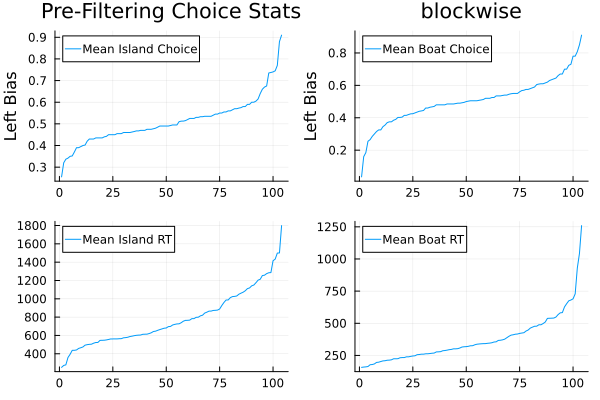

In [15]:
df1 = @chain full_df_all begin
        @subset(:state1 .== 1)
        groupby(:sub)
        @combine(:meanIslandChoice = mean(:action1Left))
end
p1 = plot(sort(df1.meanIslandChoice), label="Mean Island Choice", ylabel="Left Bias", legend=:topleft, title="Pre-Filtering Choice Stats")

df2 = @chain full_df_all begin
        @subset(:state1 .== 1)
        @subset(:state3 .> 3)
        groupby(:sub)
        @combine(:meanBoatChoice = mean(:action2Left))
end
p2 = plot(sort(df2.meanBoatChoice), label="Mean Boat Choice", ylabel="Left Bias", legend=:topleft, title=study_name)
p3 = plot(sort(island_rts), label="Mean Island RT", legend=:topleft)
p4 = plot(sort(boat_rts), label="Mean Boat RT", legend=:topleft)
plot(p1, p2, p3, p4)

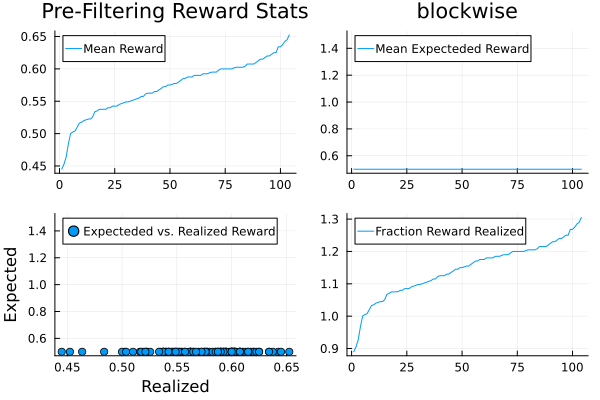

In [16]:
r = @chain begin full_df_all
    groupby(:subject)
    @combine(:reward_mean = mean(:reward))
end
p1 = plot(sort(r.reward_mean), label="Mean Reward", legend=:topleft, title="Pre-Filtering Reward Stats")
p2 = plot(sort(reward_probs), label="Mean Expecteded Reward", legend=:topleft, title=study_name)
p3 = scatter(r.reward_mean, reward_probs, label="Expecteded vs. Realized Reward", xlabel="Realized", ylabel="Expected", legend=:topleft)
p4 = plot(sort(r.reward_mean ./ reward_probs), label="Fraction Reward Realized", legend=:topleft)
plot(p1, p2, p3, p4)

## Filter data

In [17]:
println("Incorrect numbers of trials:\n")
data_ids_bad_trialcount = []
for i in 1:NS
    nrows = sum([any([startswith(row["internal_node_id"], n) for n in node_ids]) && (row["trial_type"] == "sailing-trial") for row in JSON.parse(GZip.open(filenames[i]))])
    if nrows != ntrials
        println("file $(data_ids[i]) $(nrows)")
        push!(data_ids_bad_trialcount, data_ids[i])
    end
end

Incorrect numbers of trials:



In [26]:
println("Outliers on island RT:")
data_ids_bad_island_rts = []
z_island_rts = (island_rts .- mean(island_rts))./std(island_rts)
island_outliers = findall(abs.(z_island_rts) .> 3) # Only care about excessively long responses, short could be pre-cued
for i in island_outliers
    println("$i:\t$(data_ids[i])\t$(round(island_rts[i];digits=1))\t(z=$(round(z_island_rts[i];digits=1)))")
    push!(data_ids_bad_island_rts, data_ids[i])
end

Outliers on island RT:
24:	1799.2	(z=3.4)


In [25]:
println("Outliers on boat RT:")
data_ids_bad_boat_rts = []
z_boat_rts = abs.((boat_rts .- mean(boat_rts))./std(boat_rts))
boat_outliers = findall(z_boat_rts .> 3) # Only care about excessively long responses, short could be pre-cued
for i in boat_outliers
    println("$i:\t$(data_ids[i])\t$(round(boat_rts[i];digits=1))\t(z=$(round(z_boat_rts[i];digits=1)))")
    push!(data_ids_bad_boat_rts, data_ids[i])
end

Outliers on boat RT:
4:	929.4	(z=3.1)
16:	1259.4	(z=4.9)
37:	1042.6	(z=3.7)


In [20]:
data_ids_bad = unique(vcat(data_ids_bad_trialcount, data_ids_bad_island_rts, data_ids_bad_boat_rts))
data_ids_good = data_ids[.!in(data_ids_bad).(data_ids)]
full_df_bad = full_df_all[in(data_ids_bad).(full_df_all[:,:assignment]), :];
full_df = full_df_all[in(data_ids_good).(full_df_all[:,:assignment]), :];
subjects_good = unique(full_df.sub)
for i in 1:length(subjects_good)
    inds = full_df.sub .== subjects_good[i]
    full_df[inds, :sub] .= i
    full_df[inds, :subject] .= lpad(i,3,"0")
end
filenames_good = "$(data_dir)/$(study_dir)/" .* data_ids_good .* ".json.gz"
filenames_bad = "$(data_dir)/$(study_dir)/" .* data_ids_bad .* ".json.gz"
println("Good Subjects: $(length(data_ids_good))")
println("Filtered Subjects: $(length(data_ids_bad))")

Good Subjects: 100
Filtered Subjects: 4


## Save Data

In [34]:
save("$(derived_dir)/$(file_prefix).jld2", "full_df", full_df)

## Subject Performance

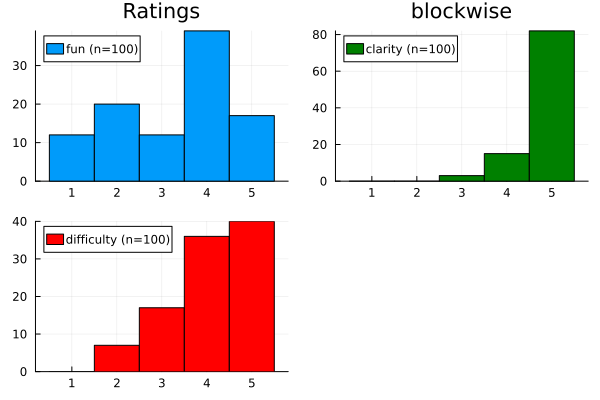

In [27]:
responses = [JSON.parse(GZip.open(filenames_good[i]))[end-1]["responses"] for i in 1:length(filenames_good)]
p1 = histogram(
    [parse(Int, r["fun"]) for r in responses],
    bins=(0:5).+0.5,
    label="fun (n=$(length(filenames_good)))",
    legend=:topleft,
    title="Ratings")
p2 = histogram(
    [parse(Int, r["clarity"]) for r in responses],
    bins=(0:5).+0.5,
    label="clarity (n=$(length(filenames_good)))",
    color="green",
    legend=:topleft,
    title=study_name)
p3 = histogram(
    [parse(Int, r["difficulty"]) for r in responses],
    bins=(0:5).+0.5,
    label="difficulty (n=$(length(filenames_good)))",
    color="red",
    legend=:topleft)
p = plot(p1,p2,p3)
savefig("$(img_dir)/$(file_prefix)_ratings.pdf")
p

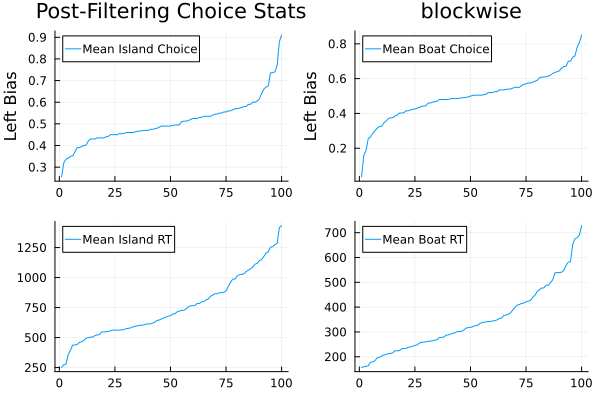

In [29]:
df1 = @chain full_df begin
        @subset(:state1 .== 1)
        groupby(:sub)
        @combine(:meanIslandChoice = mean(:action1Left))
end
p1 = plot(sort(df1.meanIslandChoice), label="Mean Island Choice", ylabel="Left Bias", legend=:topleft, title="Post-Filtering Choice Stats")

df2 = @chain full_df begin
        @subset(:state1 .== 1)
        @subset(:state3 .> 3)
        groupby(:sub)
        @combine(:meanBoatChoice = mean(:action2Left))
end
p2 = plot(sort(df2.meanBoatChoice), label="Mean Boat Choice", ylabel="Left Bias", legend=:topleft, title=study_name)
p3 = plot(sort(island_rts[.!in(data_ids_bad).(data_ids)]), label="Mean Island RT", legend=:topleft)
p4 = plot(sort(boat_rts[.!in(data_ids_bad).(data_ids)]), label="Mean Boat RT", legend=:topleft)
p = plot(p1, p2, p3, p4)
savefig("$(img_dir)/$(file_prefix)_stats_choice.pdf")
p

## Feedback

In [22]:
# open("$(derived_dir)/$(file_prefix)_feedback.txt", "w") do file
#     printstyled("Feedback:\n", bold=true)
#     write(file, "$(study_name)\n")
#     write(file, "Feedback:\n\n")
#     for i in 1:length(filenames_good)
#         try
#             feedback = JSON.parse(GZip.open(filenames_good[i]))[end-1]["responses"]["feedback"]
#             if length(feedback) > 4
#                 println("$(feedback)\n")
#                 write(file, "$(feedback)\n\n")
#             end
#         catch KeyError
#         end
#     end
# end

In [23]:
# open("$(derived_dir)/$(file_prefix)_strategy.txt", "w") do file
#     printstyled("Strategy:\n", bold=true)
#     write(file, "$(study_name)\n")
#     write(file, "Strategy:\n\n")
#     for i in 1:length(filenames_good)
#         try
#             strategy = JSON.parse(GZip.open(filenames_good[i]))[end-1]["responses"]["strategy"]
#             if length(strategy) > 4
#                 println("$(strategy)\n")
#                 write(file, "$(strategy)\n\n")
#             end
#         catch KeyError
#         end
#     end
# end